Load libraries, datasets and plot correlation between urine metabolites and exposure after birth to chemicals 

In [39]:
using DataFrames, Statistics, LinearAlgebra, Plots, CategoricalArrays
using JLD, Distributions, JSON, HTTP, StatsPlots, StatsBase, Parquet

In [2]:
resp = HTTP.get("https://provanik.s3.us-east-2.amazonaws.com/data_serum.json")
str = String(resp.body)
jobj = JSON.Parser.parse(str)

Dict{String, Any} with 4 entries:
  "serum_data"   => Any[Dict{String, Any}("blood_sam4"=>18.9167, "ethn_PC2"=>6.…
  "serum_sample" => Any[Dict{String, Any}("1"=>-0.6735, "519"=>-1.1811, "788"=>…
  "codebook"     => Any[Dict{String, Any}("family"=>"Air Pollution", "labelssho…
  "exposure_pre" => Any[Dict{String, Any}("hs_dmp_madj_Log2"=>2.9434, "hs_mnbp_…

In [40]:
codebook = vcat(DataFrame.(jobj["codebook"])...,cols = :union);
serum_data = vcat(DataFrame.(jobj["serum_data"])...,cols = :union);
serum_sample = vcat(DataFrame.(jobj["serum_sample"])...,cols = :union);

In [41]:
path = "C:\\Users\\nicol\\Documents\\Metabolomics\\data\\tables_format\\"
exposure = DataFrame(read_parquet(string(path,"covariates.parquet")));

Select from the codebook the variables name

In [35]:
#show(codebook[:,names(codebook)[[12,11,10,9,8,7,3,2]]], allcols = true)
tmp = filter([:period, :var_type, :domain, :period_postnatal, :family, :subfamily] => (x,y,z,w,p,r) -> x == "Postnatal" && 
        y == "numeric" && z != "Covariates" && z!= "Phenotype" && (w == "NA" || contains.(w, "Year")) && 
       !(contains.(p,"Traffic") || contains.(p,"Social and economic capital") || contains.(p,"Built environment") || 
        contains.(p,"Indoor air") || contains.(p,"Lifestyle") || contains.(p,"Natural Spaces")),
        codebook)
show(tmp[:,names(codebook)[[12,9,7,3,2]]], allcols = true)

51×5 DataFrame
 Row │ variable_name           subfamily     period     family           domain            
     │ String                  String        String     String           String            
─────┼─────────────────────────────────────────────────────────────────────────────────────
   1 │ hs_no2_yr_hs_h_Log      NO2           Postnatal  Air Pollution    Outdoor exposures
   2 │ hs_pm10_yr_hs_h_None    PM10          Postnatal  Air Pollution    Outdoor exposures
   3 │ hs_pm25_yr_hs_h_None    PM2.5         Postnatal  Air Pollution    Outdoor exposures
   4 │ hs_pm25abs_yr_hs_h_Log  PMAbsorbance  Postnatal  Air Pollution    Outdoor exposures
   5 │ hs_as_c_Log2            As            Postnatal  Metals           Chemicals
   6 │ hs_cd_c_Log2            Cd            Postnatal  Metals           Chemicals
   7 │ hs_co_c_Log2            Co            Postnatal  Metals           Chemicals
   8 │ hs_cs_c_Log2            Cs            Postnatal  Metals           Chemicals
   9 │ hs_cu_

In [144]:
var_name = vcat("ID",tmp.variable_name)
environmental = exposure[:,var_name];

In [145]:
met_serum = permutedims(serum_sample,1199);
names(met_serum)[2:178];

In [146]:
DT = innerjoin(environmental, met_serum, on = :ID => :rn);
names(DT);

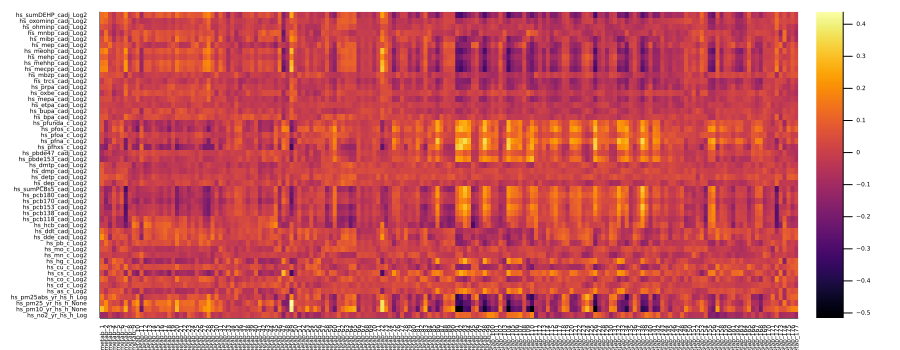

In [215]:
M = cor(Matrix{Float64}(DT[:,2:size(DT)[2]]))       # correlation matrix
MC = Matrix{Float64}(M[1:(length(var_name)-1),length(var_name):(length(var_name)+176)])
# PLOT
var_name_ = tmp.variable_name
met_serum_ = names(met_serum)[2:178]
(n,m) = size(MC)
heatmap(MC;# fc=cgrad([:white,:dodgerblue4]); 
        yticks=(1:n,var_name_), xrot=90, 
        xticks=(1:m,met_serum_), size = (900, 350),tickfontsize = 4)
#xlabel="x values", ylabel="y values",
#    title="My title"

Linear regression one by one between chemicals and metabolites (we assume chemicals &LongRightArrow; metabolites, so metabolites will be the outcome)

In [216]:
w = reshape([[x,y]  for x=met_serum_, y=var_name_],length(met_serum_)*length(var_name_));
tmp = mapreduce(permutedims, vcat, w);

In [218]:
ewas_results = Array{Float64}(undef,9027, 6);
ewas_results = hcat(tmp,ewas_results);

In [220]:
N = size(ewas_results)[1]

for i in 1:N
    X_tmp = Array{Float64, 2}(hcat(ones(size(DT, 1)),DT[:,ewas_results[i,2]]))
    Y_tmp = convert.(Float64, DT[:,ewas_results[i,1]])

    β = X_tmp\Y_tmp
    σ² = sum((Y_tmp - X_tmp*β).^2)/(size(X_tmp,1)-size(X_tmp,2))
    Σ = σ²*inv(X_tmp'*X_tmp)
    std_coeff = sqrt.(diag(Σ))
    
    ewas_results[i,3] = β[2]
    ewas_results[i,4] = std_coeff[2]
    ewas_results[i,5] = β[2]/std_coeff[2]
    ewas_results[i,6] = cdf(TDist(size(X_tmp,1)-size(X_tmp,2)), -abs(β[2]/std_coeff[2]))
    ewas_results[i,7] = β[2] - quantile(TDist(size(X_tmp,1)-size(X_tmp,2)), 0.975)*std_coeff[2]
    ewas_results[i,8] = β[2] + quantile(TDist(size(X_tmp,1)-size(X_tmp,2)), 0.975)*std_coeff[2]
end

In [222]:
ewas_results = DataFrame(ewas_results,:auto)
rename!(ewas_results, ["outcome","variable","beta","std_error","t_value","p_value","CI0025","CI0975"]);

In [239]:
ewas_results.p_value_bonf = ewas_results.p_value .< (0.05/51);

In [240]:
show(ewas_results[ewas_results.p_value_bonf  .== 1,[1,2,3,6,9]], allcols = true)

2041×5 DataFrame
  Row │ outcome    variable              beta        p_value      p_value_bonf 
      │ Any        Any                   Any         Any          Bool         
──────┼────────────────────────────────────────────────────────────────────────
    1 │ metab_1    hs_no2_yr_hs_h_Log    -0.214236   3.1847e-5            true
    2 │ metab_2    hs_no2_yr_hs_h_Log    -0.0303829  0.000157023          true
    3 │ metab_5    hs_no2_yr_hs_h_Log    -0.0461642  5.19399e-5           true
    4 │ metab_10   hs_no2_yr_hs_h_Log    0.0980607   5.1978e-7            true
    5 │ metab_18   hs_no2_yr_hs_h_Log    0.0780808   0.000973381          true
    6 │ metab_20   hs_no2_yr_hs_h_Log    -0.0488934  0.000687419          true
    7 │ metab_23   hs_no2_yr_hs_h_Log    0.0386034   0.000524394          true
    8 │ metab_28   hs_no2_yr_hs_h_Log    0.097716    1.16031e-9           true
    9 │ metab_47   hs_no2_yr_hs_h_Log    -0.0573568  8.62144e-9           true
   10 │ metab_51   hs_no2_yr_hs_

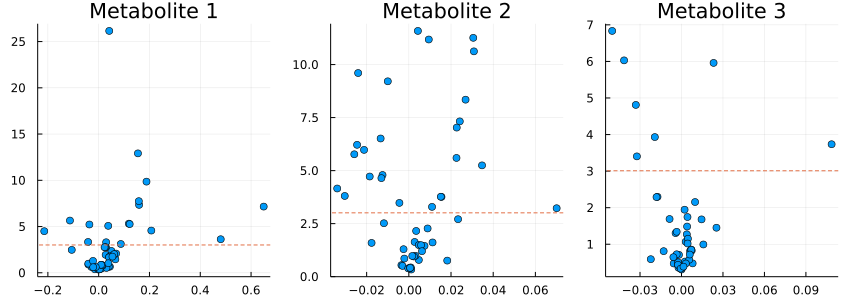

In [250]:
p1 = scatter(ewas_results[ewas_results.outcome .== "metab_1",3], 
        - log10.(ewas_results[ewas_results.outcome .== "metab_1",6]),
        title = "Metabolite 1", label = "")
hline!(p1,[- log10.(0.05/51)], linestyle=:dash, label = "Bonferroni")

p2 = scatter(ewas_results[ewas_results.outcome .== "metab_2",3], 
        - log10.(ewas_results[ewas_results.outcome .== "metab_2",6]),
        title = "Metabolite 2", label = "")
hline!(p2,[- log10.(0.05/51)], linestyle=:dash, label = "Bonferroni")

p3 = scatter(ewas_results[ewas_results.outcome .== "metab_3",3], 
        - log10.(ewas_results[ewas_results.outcome .== "metab_3",6]),
        title = "Metabolite 3", label = "")
hline!(p3,[- log10.(0.05/51)], linestyle=:dash, label = "Bonferroni")

plot(p1, p2, p3, layout = (1, 3), legend = false, size = (850, 300))

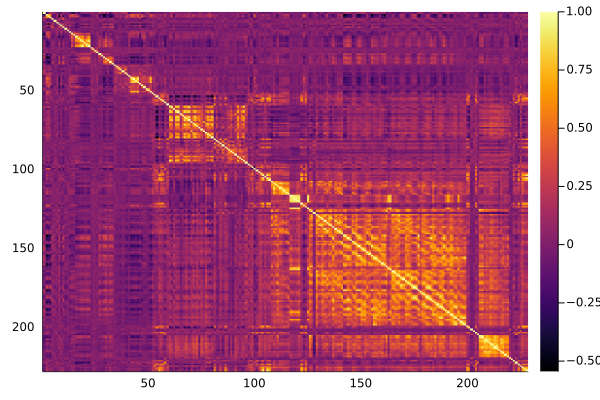

In [174]:
heatmap(M,yflip=true)

In [208]:
Df_cor = DataFrame(M,vcat(var_name_,met_serum_))
Df_cor[:,:label] = vcat(var_name_,met_serum_)
MDf_cor = DataFrames.stack(Df_cor, 1:228);
first(MDf_cor, 5)

,label,variable,value
,String,String,Float64
1,hs_no2_yr_hs_h_Log,hs_no2_yr_hs_h_Log,1.0
2,hs_pm10_yr_hs_h_None,hs_no2_yr_hs_h_Log,-0.278069
3,hs_pm25_yr_hs_h_None,hs_no2_yr_hs_h_Log,-0.01413
4,hs_pm25abs_yr_hs_h_Log,hs_no2_yr_hs_h_Log,0.222196
5,hs_as_c_Log2,hs_no2_yr_hs_h_Log,0.0656387


In [209]:
filter([:label, :variable, :value] => (x,y,z) -> x!=y,MDf_cor)

,label,variable,value
,String,String,Float64
1,hs_pm10_yr_hs_h_None,hs_no2_yr_hs_h_Log,-0.278069
2,hs_pm25_yr_hs_h_None,hs_no2_yr_hs_h_Log,-0.01413
3,hs_pm25abs_yr_hs_h_Log,hs_no2_yr_hs_h_Log,0.222196
4,hs_as_c_Log2,hs_no2_yr_hs_h_Log,0.0656387
5,hs_cd_c_Log2,hs_no2_yr_hs_h_Log,0.0672456
6,hs_co_c_Log2,hs_no2_yr_hs_h_Log,-0.127809
7,hs_cs_c_Log2,hs_no2_yr_hs_h_Log,-0.068465
8,hs_cu_c_Log2,hs_no2_yr_hs_h_Log,-0.131308
9,hs_hg_c_Log2,hs_no2_yr_hs_h_Log,0.115589


Plot variance analysis for principal component analysis

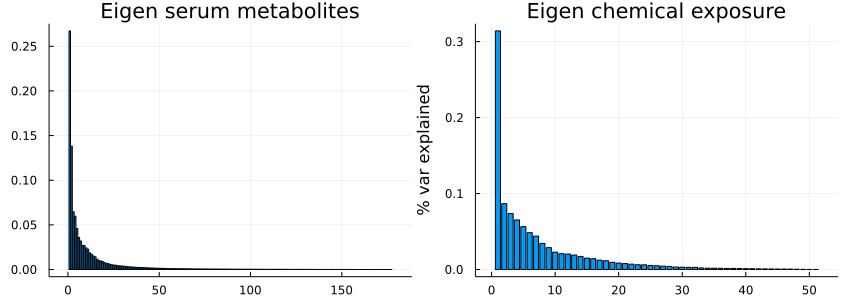

In [191]:
MM = Matrix{Float64}(met_serum[:,2:178])
eig_MM = eigen(cov(MM))
tmp_bar = sort(eig_MM.values/sum(eig_MM.values),rev = true)
p = bar(1:177,tmp_bar, #ylabel = "% var explained",xlabel = "Components",
    title = "Eigen serum metabolites")

MCh = Matrix{Float64}(environmental[:,2:52])
eig_MCh = eigen(cov(MCh))
tmp_bar = sort(eig_MCh.values/sum(eig_MCh.values),rev = true)
q = bar(1:51,tmp_bar, ylabel = "% var explained",
        #xlabel = "Components",
        title = "Eigen chemical exposure")

plot(p, q, layout = (1, 2), legend = false, size = (850, 300))